Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Found 8000 files belonging to 8 classes.
Using 1600 files for validation.
Epoch 1/7
50/50 ━━━━━━━━━━━━━━━━━━━━ 1571s 30s/step - accuracy: 0.6527 - loss: 1.9421 - val_accuracy: 0.4964 - val_loss: 15.1299 - learning_rate: 0.0010
Epoch 2/7
50/50 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9600 - loss: 0.1187 - val_accuracy: 0.5553 - val_loss: 10.7428 - learning_rate: 0.0010
Epoch 3/7
50/50 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9916 - loss: 0.0281 - val_accuracy: 0.5697 - val_loss: 8.2784 - learning_rate: 0.0010
Epoch 4/7
50/50 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9958 - loss: 0.0175 - val_accuracy: 0.6118 - val_loss: 7.0540 - learning_rate: 0.0010
Epoch 5/7
50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9978 - loss: 0.0115 - val_accuracy: 0.6262 - val_loss: 6.1984 - learning_rate: 0.0010
Epoch 6/7
50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9966 - loss: 0.0106 - val_accuracy: 0.

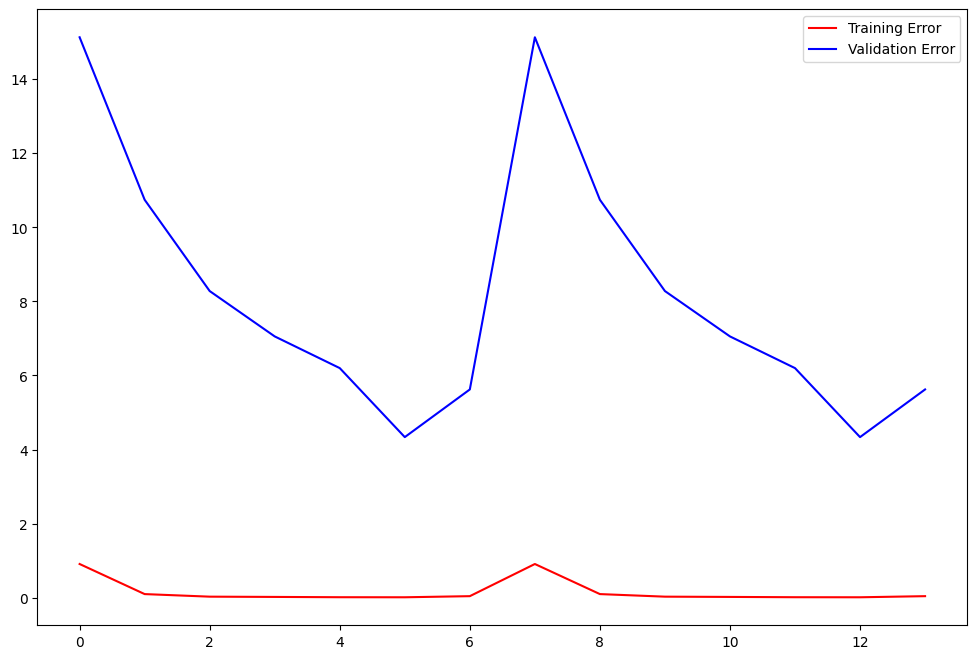

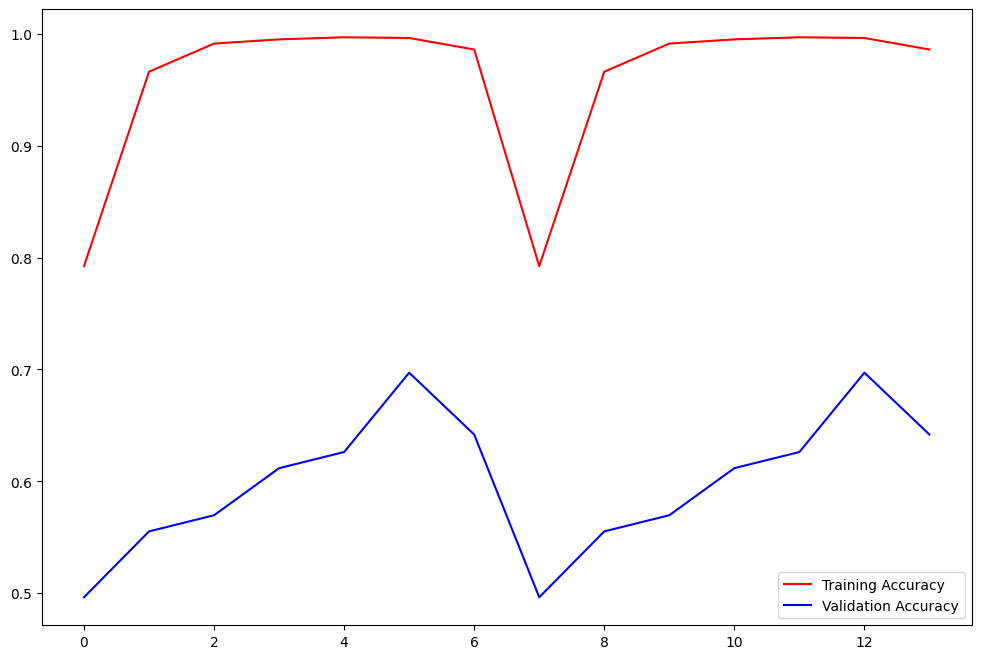

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy: 0.64


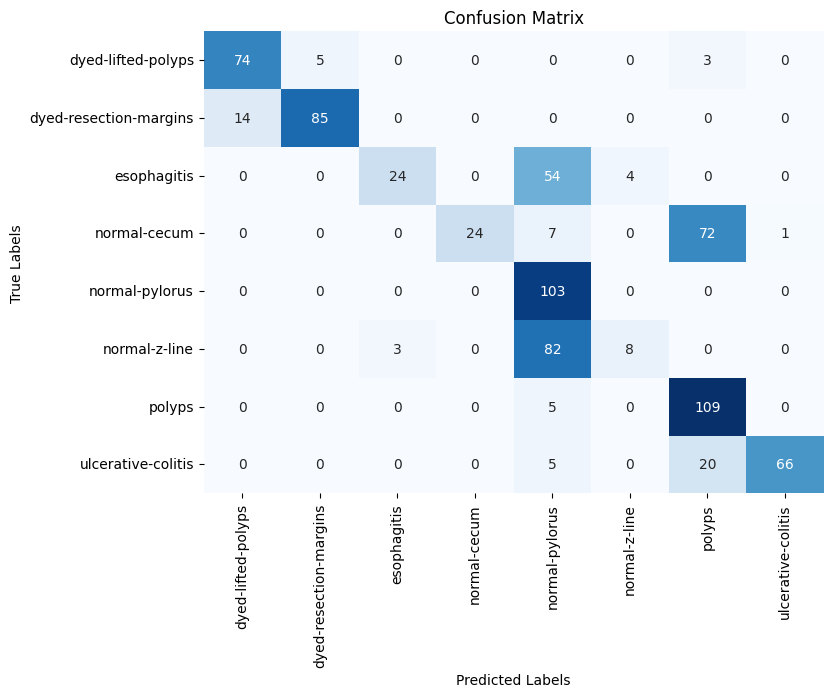

Precision: 0.77
Recall: 0.64
F1 Score: 0.60
Final Training Accuracy: 0.99
Final Validation Accuracy: 0.64


In [2]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix, classification_report,
    accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
)
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

dataset_path = "/content/drive/MyDrive/kvasir-dataset-v2/kvasir-dataset-v2"
image_size = 224, 224
batch_size = 128

train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size)

class_names = train_ds.class_names

# Splitting Validation Dataset for Validation and Test
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

# Prefetching Datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Constructing and Compiling the Model
model = Sequential()
base_model = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True
model.add(base_model)
model.add(Flatten())
model.add(Dense(8, activation='softmax'))
model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
best = ModelCheckpoint(filepath="training_weights/best/model_best_val_accuracy.ckpt.weights.h5",
                       save_weights_only=True, monitor="val_accuracy", mode="max", save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=20)

# Training the model
model.fit(train_ds, epochs=7, validation_data=val_ds, callbacks=[reduce_lr, best, early_stop])

# Saving the model
model.save("finalMobileNetv3.h5")

# Plotting Training and Validation Metrics
history = model.history
loss = history.history['loss'] + history.history['loss']
val_loss = history.history['val_loss'] + history.history['val_loss']
accuracy = history.history['accuracy'] + history.history['accuracy']
val_accuracy = history.history['val_accuracy'] + history.history['val_accuracy']

plt.figure(figsize=(12, 8))
plt.plot(loss, color='r', label='Training Error')
plt.plot(val_loss, color='b', label='Validation Error')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(accuracy, color='r', label='Training Accuracy')
plt.plot(val_accuracy, color='b', label='Validation Accuracy')
plt.legend()
plt.show()

# Plotting the Confusion Matrix and Calculating Metrics
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate Precision, Recall, and F1 Score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


# Access the last epoch's training and validation accuracy
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_training_accuracy:.2f}")
print(f"Final Validation Accuracy: {final_validation_accuracy:.2f}")
